In [26]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from graphxai.datasets import ShapeGGen
from graphxai.explainers import GradExplainer, GNNExplainer, PGMExplainer, GraphLIME
from graphxai.metrics.base import graph_exp_acc, graph_exp_faith, graph_exp_stability
from torch_geometric.utils import k_hop_subgraph
import numpy as np
import networkx as nx
from graphxai.utils import Explanation, EnclosingSubgraph
import matplotlib.pyplot as plt

In [2]:
# Generate dataset ShapeGGen
dataset = ShapeGGen(model_layers=3, num_graphs=1, make_explanations=True)
# Ambil graph dari dataset
data = dataset.graph  # Dataset hanya memiliki satu graf
explanation = dataset.explanations  # atau mungkin dataset.explanations jika atributnya berbentuk list

print(f"Graph Data: {data}")
print(f"Graph Explanations: {explanation}")
print(f"Explanation Available: {'Yes' if explanation is not None else 'No'}")

  0%|          | 0/45 [00:00<?, ?it/s]

100%|██████████| 45/45 [00:00<00:00, 233.20it/s]


Graph Data: Data(x=[131, 11], edge_index=[2, 372], y=[131], shape=[131])
Graph Explanations: [[<graphxai.utils.explanation.Explanation object at 0x000001C4361BDDF0>], [<graphxai.utils.explanation.Explanation object at 0x000001C44E414940>], [<graphxai.utils.explanation.Explanation object at 0x000001C4361BD880>], [<graphxai.utils.explanation.Explanation object at 0x000001C4361E4B20>], [<graphxai.utils.explanation.Explanation object at 0x000001C4361E4730>], [<graphxai.utils.explanation.Explanation object at 0x000001C4361E46A0>], [<graphxai.utils.explanation.Explanation object at 0x000001C4361E4100>], [<graphxai.utils.explanation.Explanation object at 0x000001C4361E4130>], [<graphxai.utils.explanation.Explanation object at 0x000001C45040CB80>], [<graphxai.utils.explanation.Explanation object at 0x000001C45040CBE0>], [<graphxai.utils.explanation.Explanation object at 0x000001C45040CAC0>], [<graphxai.utils.explanation.Explanation object at 0x000001C45040C7C0>], [<graphxai.utils.explanation.E

In [6]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

#  Model training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(torch.unique(data.y))  # Get number of unique classes from labels
model = GCN(data.x.shape[1], 16, num_classes).to(device)

# Create train mask (for example, using 80% of nodes for training)
num_nodes = data.x.size(0)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_indices = torch.randperm(num_nodes)[:int(0.8 * num_nodes)]
train_mask[train_indices] = True
data.train_mask = train_mask

data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

for epoch in range(310):
    loss = train()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

Epoch 0, Loss: 0.8054
Epoch 20, Loss: 0.6201
Epoch 40, Loss: 0.5683
Epoch 60, Loss: 0.5178
Epoch 80, Loss: 0.4613
Epoch 100, Loss: 0.4065
Epoch 120, Loss: 0.3608
Epoch 140, Loss: 0.3251
Epoch 160, Loss: 0.2944
Epoch 180, Loss: 0.2676
Epoch 200, Loss: 0.2432
Epoch 220, Loss: 0.2205
Epoch 240, Loss: 0.1993
Epoch 260, Loss: 0.1807
Epoch 280, Loss: 0.1644
Epoch 300, Loss: 0.1493


In [29]:
class SafeGraphLIME(GraphLIME):
    def get_explanation_node(self, node_idx, x, edge_index, *args, **kwargs):
        # Pastikan model ada di device yang benar (kalau CPU/GPU beda)
        self.model = self.model.to(x.device)

        # Panggil GraphLIME asli, tapi log sebelum dan sesudah
        print(f"[SafeGraphLIME] Memulai explain node {node_idx}")
        result = super().get_explanation_node(node_idx, edge_index, x, *args, **kwargs)
        print(f"[SafeGraphLIME] Selesai explain node {node_idx}")

        return result


# Inisialisasi explainer
grad_explainer = GradExplainer(model, criterion=F.nll_loss)
gnn_explainer = GNNExplainer(model)
pgm_explainer = PGMExplainer(model, explain_graph=False)
lime_explainer = SafeGraphLIME(model)

# Ambil satu node untuk dijelaskan
node_idx = 10  # Pastikan node ini valid dan ada di train mask
x, edge_index = data.x, data.edge_index

# === Ambil Subgraph k-hop (khusus Grad dan GNN) ===
num_hops = 2
subset, sub_edge_index, mapping, _ = k_hop_subgraph(
    node_idx, num_hops, data.edge_index, relabel_nodes=True, num_nodes=data.num_nodes
)
sub_x = data.x[subset]

# Grad dan GNN pakai subgraph
grad_explanation = grad_explainer.get_explanation_node(mapping, sub_x, sub_edge_index)
gnn_explanation = gnn_explainer.get_explanation_node(mapping, sub_x, sub_edge_index)

# PGM dan GraphLIME pakai full graph
x, edge_index = dataset.graph.x, dataset.graph.edge_index
print(f"Check sebelum GraphLIME:")
print(f"x shape: {x.shape}")
print(f"edge_index shape: {edge_index.shape}")
print(f"edge_index max node id: {edge_index.max().item()}")

assert x.shape[0] > edge_index.max().item(), "Jumlah node di x tidak sesuai edge_index!"

pgm_explanation = pgm_explainer.get_explanation_node(node_idx, x, edge_index)
lime_explanation = lime_explainer.get_explanation_node(node_idx, x, edge_index)


Check sebelum GraphLIME:
x shape: torch.Size([131, 11])
edge_index shape: torch.Size([2, 372])
edge_index max node id: 130


  0%|          | 0/1000000 [00:00<?, ?it/s]

[SafeGraphLIME] Memulai explain node 10
[SafeGraphLIME] Selesai explain node 10



c:\Users\Lingg\miniconda3\envs\graphxai_env\lib\site-packages\sklearn\linear_model\_base.py:121: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


In [43]:
# Ground truth explanation dari ShapeGGen
ground_truth = dataset.explanations[node_idx][0]  # Extract the Explanation object from the list

# Evaluasi Graph Explanation Accuracy (GEA)
gea_grad = graph_exp_acc(ground_truth, grad_explanation)
gea_gnn = graph_exp_acc(ground_truth, gnn_explanation)
gea_pgm = graph_exp_acc(ground_truth, pgm_explanation)
# khusus LIME (karena lebih ke feature importance bukan node jadi di konversi ke node)
# Dapatkan feature importance dari GraphLIME
lime_explanation = lime_explainer.get_explanation_node(node_idx, x, edge_index)

# Konversi feature importance GraphLIME ke node importance
node_importance = lime_explanation.feature_imp.mean().item()
lime_node_importance = torch.zeros(data.num_nodes)  # Untuk full graph
lime_node_importance[node_idx] = node_importance

# Buat node_reference lengkap untuk full graph
node_reference = {i: i for i in range(data.num_nodes)}

# Buat edge_mask manual (untuk mendukung versi lama torch_geometric)
edge_mask = torch.zeros(data.edge_index.shape[1], dtype=torch.bool)
for edge_id, (src, dst) in enumerate(data.edge_index.T):
    if src in subset and dst in subset:
        edge_mask[edge_id] = True

class ExplanationCompat(Explanation):
    def __init__(self, enc_subgraph=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.enc_subgraph = enc_subgraph

lime_exp = ExplanationCompat(
    node_imp=lime_node_importance,
    node_idx=node_idx,
    enc_subgraph=EnclosingSubgraph(
        nodes=subset,
        edge_index=sub_edge_index,
        inv=mapping,
        edge_mask=edge_mask,
        directed=False
    )
)

lime_exp.node_reference = node_reference  # Ini kunci utama!
gea_lime = graph_exp_acc(ground_truth, lime_exp)

print("Graph Explanation Accuracy:")
print(f"Grad: {gea_grad:.4f}")
print(f"GNNExplainer: {gea_gnn:.4f}")
print(f"PGMExplainer: {gea_pgm:.4f}")
print(f"GraphLIME: {gea_lime:.4f}")

# Evaluasi Graph Explanation Faithfulness (GEF)
gef_grad = graph_exp_faith(grad_explanation, dataset, model)
gef_gnn = graph_exp_faith(gnn_explanation, dataset, model)
gef_pgm = graph_exp_faith(pgm_explanation, dataset, model)
gef_lime = graph_exp_faith(lime_exp, dataset, model)
print("\nGraph Explanation Faithfulness:")
print(f"Grad: {gef_grad:.4f}")
print(f"GNNExplainer: {gef_gnn:.4f}")
print(f"PGMExplainer: {gef_pgm:.4f}")
print(f"GraphLIME: {gef_lime:.4f}")

[SafeGraphLIME] Memulai explain node 10
[SafeGraphLIME] Selesai explain node 10
Graph Explanation Accuracy:
Grad: 0.0000
GNNExplainer: 0.3846
PGMExplainer: 0.0000
GraphLIME: 0.0000

Graph Explanation Faithfulness:
Grad: 1.0000
GNNExplainer: 1.0000
PGMExplainer: 1.0000
GraphLIME: 1.0000


c:\Users\Lingg\miniconda3\envs\graphxai_env\lib\site-packages\sklearn\linear_model\_base.py:121: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


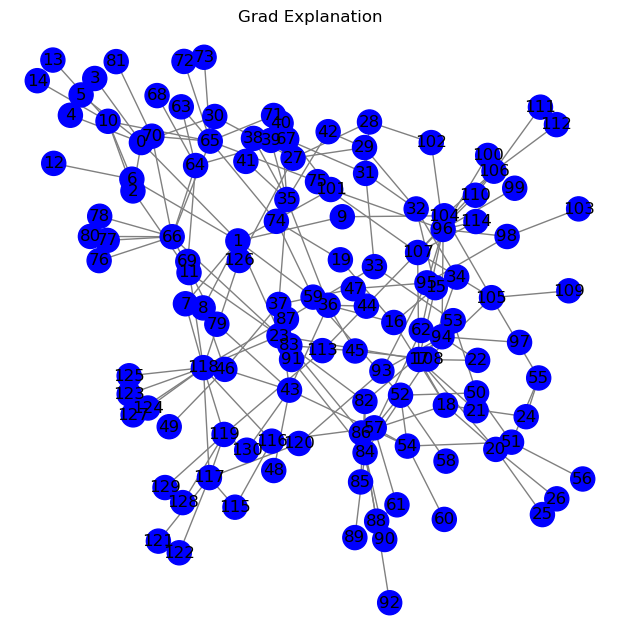

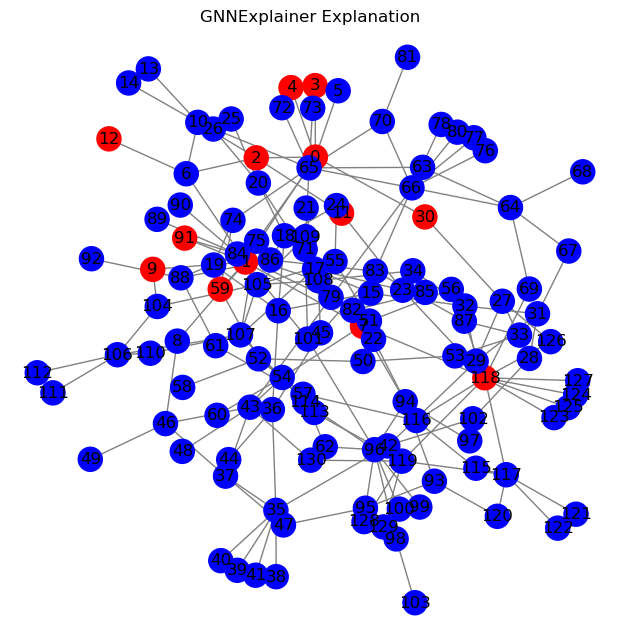

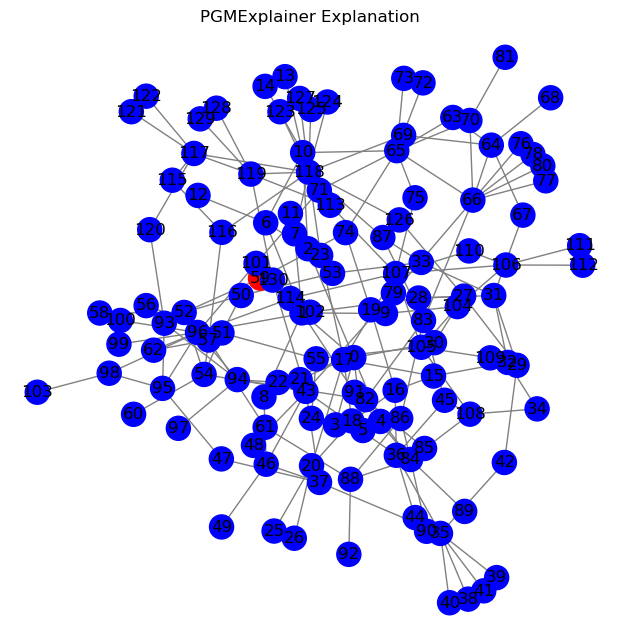

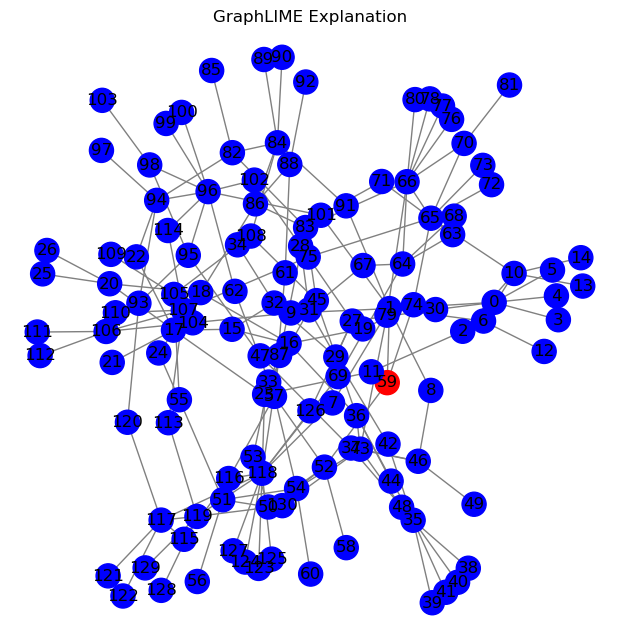

In [47]:
def visualize_explanation(graph, node_idx, explanation, title):
    plt.figure(figsize=(6, 6))
    G = nx.Graph()
    edges = graph.edge_index.cpu().numpy()
    for i in range(edges.shape[1]):
        G.add_edge(edges[0, i], edges[1, i])

    # Create a default color list for all nodes (blue)
    num_nodes = graph.x.size(0)
    node_colors = ['blue'] * num_nodes
    
    # Update colors based on node importance scores
    for node, imp in explanation.node_reference.items():
        if imp < len(explanation.node_imp):
            node_colors[node] = 'red' if explanation.node_imp[imp] > 0 else 'blue'

    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=300, edge_color="gray")
    plt.title(title)
    plt.show()


# Visualisasi hasil explainability
visualize_explanation(data, node_idx, grad_explanation, "Grad Explanation")
visualize_explanation(data, node_idx, gnn_explanation, "GNNExplainer Explanation")
visualize_explanation(data, node_idx, pgm_explanation, "PGMExplainer Explanation")
visualize_explanation(data, node_idx, pgm_explanation, "GraphLIME Explanation")

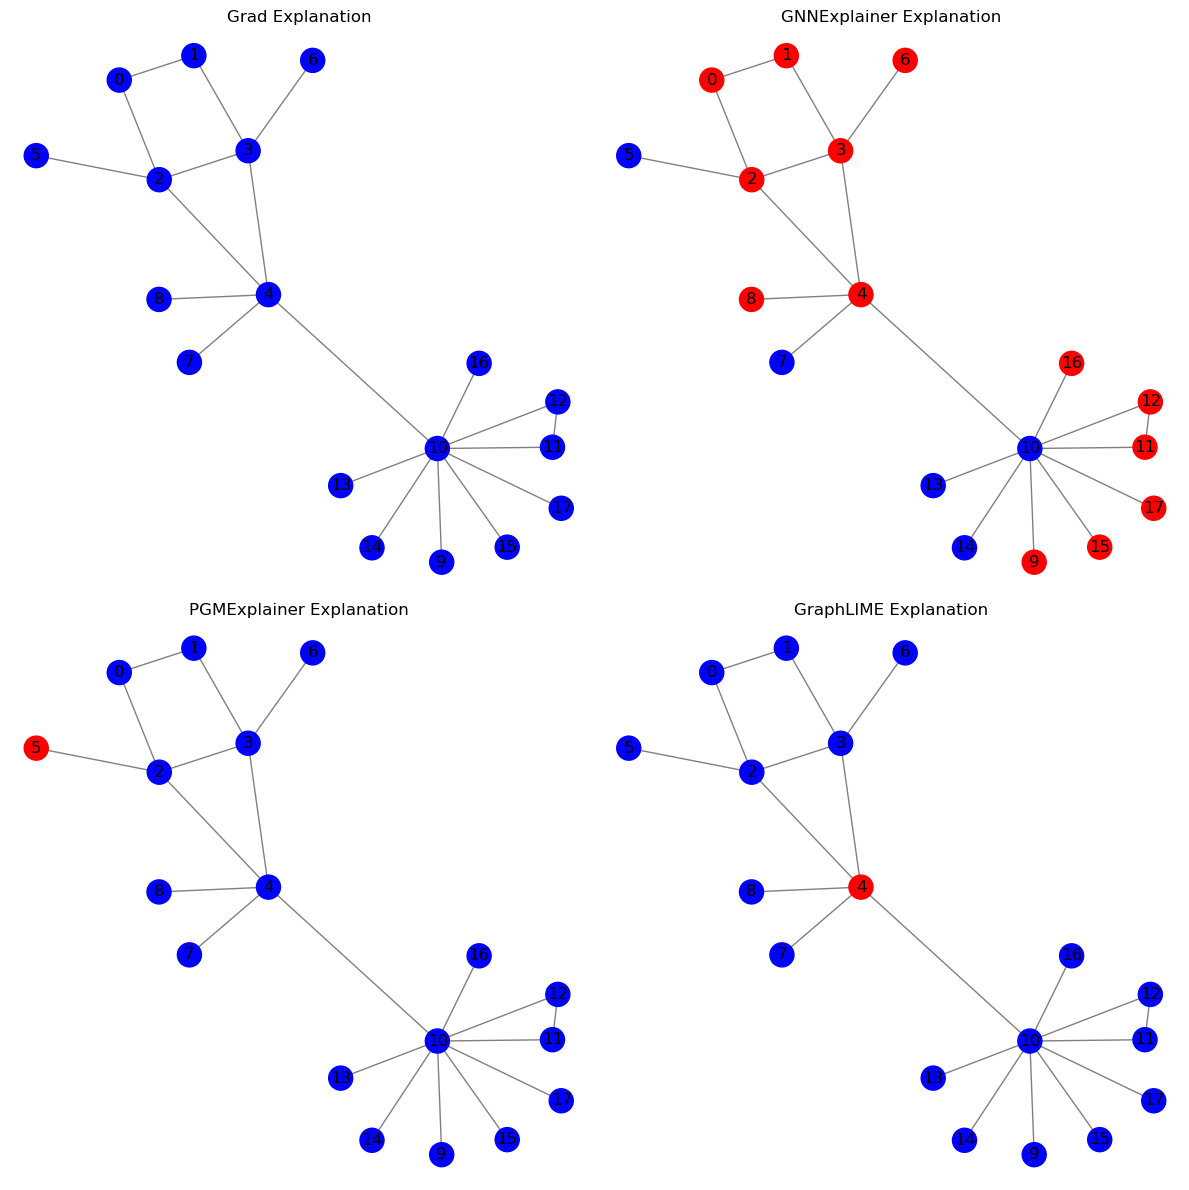

In [51]:
lime_node_importance = torch.zeros(len(subset))

# Cari posisi node_idx di subset
node_idx_in_subgraph = (subset == node_idx).nonzero(as_tuple=True)[0].item()

# Isi importance hanya untuk node yang dijelaskan
lime_node_importance[node_idx_in_subgraph] = node_importance

def visualize_all_explanations_subgraph(graph, node_idx, grad_exp, gnn_exp, pgm_exp, lime_exp, subset, sub_edge_index):
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))

    explanations = [
        ("Grad Explanation", grad_exp),
        ("GNNExplainer Explanation", gnn_exp),
        ("PGMExplainer Explanation", pgm_exp),
        ("GraphLIME Explanation", lime_exp)
    ]

    for ax, (title, explanation) in zip(axs.flat, explanations):
        visualize_explanation_subgraph(graph, node_idx, explanation, title, ax, subset, sub_edge_index)

    plt.tight_layout()
    plt.show()

def visualize_explanation_subgraph(graph, node_idx, explanation, title, ax, subset, sub_edge_index):
    G = nx.Graph()
    for i in range(sub_edge_index.shape[1]):
        src, dst = sub_edge_index[:, i]
        G.add_edge(src.item(), dst.item())

    node_colors = ['blue'] * len(subset)

    if explanation.node_imp.shape[0] == len(subset):
        # Langsung pakai (Grad, GNN, PGM)
        for local_idx, imp in enumerate(explanation.node_imp):
            node_colors[local_idx] = 'red' if imp > 0 else 'blue'
    else:
        # Khusus untuk GraphLIME (importance full graph)
        node_idx_in_subgraph = (subset == node_idx).nonzero(as_tuple=True)[0].item()
        node_colors[node_idx_in_subgraph] = 'red'  # Hanya node_idx yang berwarna merah

    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=300, edge_color="gray", ax=ax)
    ax.set_title(title)

visualize_all_explanations_subgraph(
    data, node_idx,
    grad_explanation, gnn_explanation, pgm_explanation, lime_exp,
    subset, sub_edge_index  # langsung dari k_hop_subgraph()
)

In [45]:
# Try different hyperparameters for each explainer
grad_explainer = GradExplainer(model, criterion=F.nll_loss)

gnn_explainer = GNNExplainer(
    model,
)

pgm_explainer = PGMExplainer(
    model,
    explain_graph=False,
    num_samples=100,   # More samples for better probability estimation
    perturb_mode='mean'  # How to perturb features
)

# Function to compare explanations
def compare_explanations(node_idx, data, explainers, names):
    explanations = []
    for explainer in explainers:
        exp = explainer.get_explanation_node(
            node_idx=node_idx,
            x=data.x,
            edge_index=data.edge_index
        )
        explanations.append(exp)
    
    # Print importance scores
    for name, exp in zip(names, explanations):
        print(f"\n{name} top 5 important nodes:")
        imp_scores = [(i, score) for i, score in enumerate(exp.node_imp)]
        imp_scores.sort(key=lambda x: abs(x[1]), reverse=True)
        for node, score in imp_scores[:5]:
            print(f"Node {node}: {score:.4f}")

# Compare the explainers
explainers = [grad_explainer, gnn_explainer, pgm_explainer]
names = ['GradExplainer', 'GNNExplainer', 'PGMExplainer']
compare_explanations(node_idx, data, explainers, names)

  0%|          | 0/1000000 [00:00<?, ?it/s]


GradExplainer top 5 important nodes:
Node 4: -1.7831
Node 8: -1.7067
Node 7: -1.4422
Node 2: -0.6031
Node 3: -0.6031

GNNExplainer top 5 important nodes:
Node 1: 1.0000
Node 2: 1.0000
Node 3: 1.0000
Node 4: 1.0000
Node 10: 1.0000

PGMExplainer top 5 important nodes:
Node 0: 0.0000
Node 1: 0.0000
Node 2: 0.0000
Node 3: 0.0000
Node 4: 0.0000


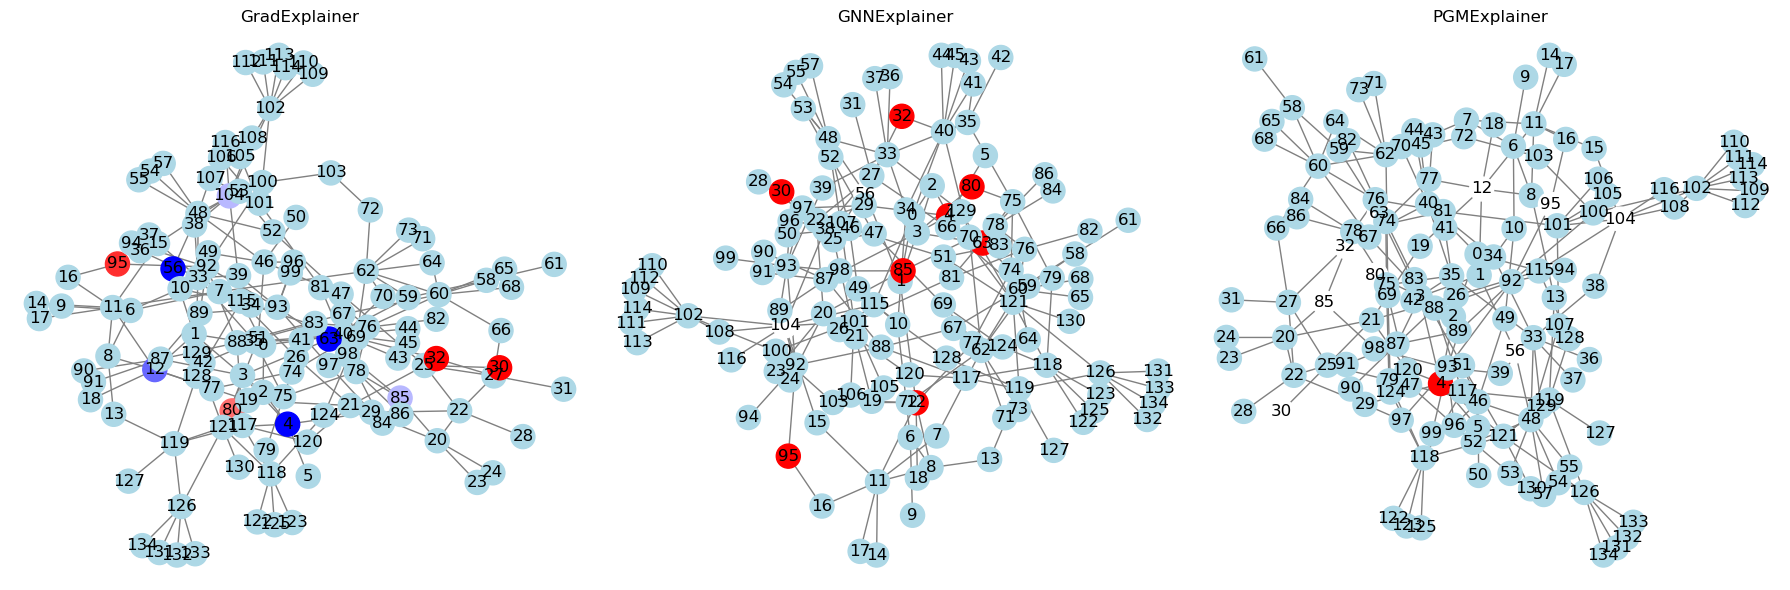

In [35]:
def plot_explanation_comparison(data, node_idx, explanations, titles):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for ax, exp, title in zip(axes, explanations, titles):
        G = nx.Graph()
        edges = data.edge_index.cpu().numpy()
        for i in range(edges.shape[1]):
            G.add_edge(edges[0, i], edges[1, i])
        
        # Create color map
        num_nodes = data.x.size(0)
        node_colors = ['lightblue'] * num_nodes  # default color
        
        # Map importance scores to colors
        for node, imp in exp.node_reference.items():
            if imp < len(exp.node_imp):
                # Convert PyTorch tensor to float
                score = float(exp.node_imp[imp].cpu())
                # Use red for positive importance, blue for negative
                if score > 0:
                    intensity = min(1.0, abs(score))
                    node_colors[node] = f'#{int(255):02x}{int(255*(1-intensity)):02x}{int(255*(1-intensity)):02x}'
                else:
                    intensity = min(1.0, abs(score))
                    node_colors[node] = f'#{int(255*(1-intensity)):02x}{int(255*(1-intensity)):02x}{int(255):02x}'
        
        pos = nx.spring_layout(G)
        nx.draw(G, pos, ax=ax, 
                with_labels=True, 
                node_color=node_colors, 
                node_size=300,
                edge_color="gray")
        ax.set_title(title)
    
    plt.tight_layout()
    plt.show()

# Get explanations and visualize
explanations = [grad_explanation, gnn_explanation, pgm_explanation]
titles = ['GradExplainer', 'GNNExplainer', 'PGMExplainer']
plot_explanation_comparison(data, node_idx, explanations, titles)